# Assignment 2

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

%matplotlib inline

In [2]:
# Exit if PUIDATA is not set. Otherwise, print the value.
puidata = os.getenv("PUIDATA")
if puidata is None:
    print("You must set the PUIDATA environment variable.")
    sys.exit(1)
else:
    print("PUIDATA=%s" % puidata)

PUIDATA=/nfshome/aaw329/PUIdata


## Acquire the Citi Bike data

In [3]:
# Download Citi Bike data into PUIDATA directory if it's not there yet
filename = "201809-citibike-tripdata.csv"  # We want the trip data from September 2018
url_base = "https://s3.amazonaws.com/tripdata"

# Check if the data is not there in .csv or .zip format
if not os.path.isfile(puidata + "/" + filename) and not os.path.isfile(puidata + "/" + filename + ".zip"):
    print("Downloading data")
    os.system("wget -O " + puidata + "/" + filename + ".zip" + " " + url_base + "/" + filename + ".zip")
    print("Unzipping data")
    os.system("unzip -d " + puidata + " " + puidata + "/" + filename + ".zip")
# Check if the data _is_ there .zip format but not .csv, in which case we just need to unzip it
elif os.path.isfile(puidata + "/" + filename + ".zip") and not os.path.isfile(puidata + "/" + filename):
    print("Unzipping data")
    os.system("unzip -d " + puidata + " " + puidata + "/" + filename + ".zip")

# Finally, make sure the correct file is present
if not os.path.isfile(puidata + "/" + filename):
    print("Problem acquiring data!")
    sys.exit(1)
else:
    print("Successfully acquired data")

Successfully acquired data


## Reformulate a new hypothesis, taking into consideration the review

NEW IDEA: younger Citi Bike riders have shorter average trip durations than older Citi Bike riders, with significance level $\alpha = 0.05$

With $\overline{TD}_{age>=40}$ meaning the average trip duration for riders age 40 or over, and $\overline{TD}_{age<40}$ meaning the average trip duration for those under age 40,

### Null hypothesis $$ H_0: \overline{TD}_{age<40} >= \overline{TD}_{age>=40} $$

### Alternative hypothesis $$ H_1: \overline{TD}_{age<40} < \overline{TD}_{age>=40} $$

## Wrangle the data


In [4]:
# Read in the .csv file with pandas
df = pd.read_csv(puidata + "/" + filename)
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1635,2018-09-01 00:00:05.2690,2018-09-01 00:27:20.6340,252.0,MacDougal St & Washington Sq,40.732264,-73.998522,366.0,Clinton Ave & Myrtle Ave,40.693261,-73.968896,25577,Subscriber,1980,1
1,132,2018-09-01 00:00:11.2810,2018-09-01 00:02:23.4810,314.0,Cadman Plaza West & Montague St,40.693830,-73.990539,3242.0,Schermerhorn St & Court St,40.691029,-73.991834,34377,Subscriber,1969,0
2,3337,2018-09-01 00:00:20.6490,2018-09-01 00:55:58.5470,3142.0,1 Ave & E 62 St,40.761227,-73.960940,3384.0,Smith St & 3 St,40.678724,-73.995991,30496,Subscriber,1975,1
3,436,2018-09-01 00:00:21.7460,2018-09-01 00:07:38.5830,308.0,St James Pl & Oliver St,40.713079,-73.998512,3690.0,Park Pl & Church St,40.713342,-74.009355,28866,Subscriber,1984,2
4,8457,2018-09-01 00:00:27.3150,2018-09-01 02:21:25.3080,345.0,W 13 St & 6 Ave,40.736494,-73.997044,380.0,W 4 St & 7 Ave S,40.734011,-74.002939,20943,Customer,1994,1


In [5]:
# Drop unnecessary columns
df.drop(df.columns.difference(["birth year", "tripduration"]), 1, inplace=True)

In [6]:
# However, we need to translate "birth year" into whether someone is over or under 40
current_year = 2018
df["under 40"] = df["birth year"].apply(lambda x: True if x > (current_year - 40) else False)  # 1 if under 40, else 0

In [7]:
# Drop the actual year
df.drop(df.columns.difference(["tripduration", "under 40"]), 1, inplace=True)

In [8]:
df.groupby(["under 40"]).mean()

,tripduration
under 40,
False,1073.921307
True,893.694544


## Plot the data

Text(0.5,1,'Average trip duration by age group')

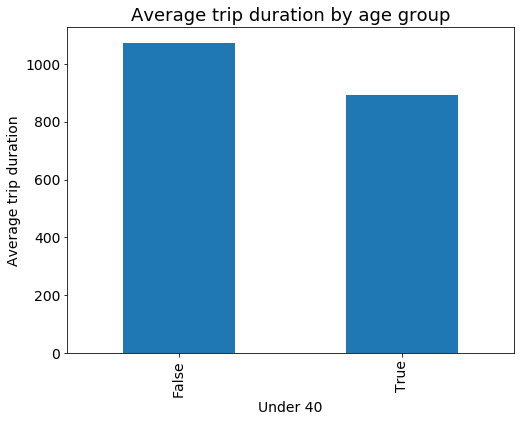

In [9]:
ax = df.groupby(["under 40"]).mean().plot(kind="bar", figsize=(8,6), fontsize=14, legend=None)
ax.set_ylabel("Average trip duration", fontsize=14)
ax.set_xlabel("Under 40", fontsize=14)
ax.set_title("Average trip duration by age group", fontsize=18)

### Figure 1: average duration of trip taken by riders that were at least 40 years old, and average duration of trip taken by riders younger than 40 years old.

## Statistical testing (t-test)

In [10]:
under = df[df["under 40"] == True]
not_under = df[df["under 40"] == False]

scipy.stats.ttest_ind(under["tripduration"],
                      not_under["tripduration"]
                     )

Ttest_indResult(statistic=-15.386982582638666, pvalue=2.016624367294345e-53)

Since the p-value obtained from the t-test was extremely small, we can reject the null hypothesis with our chosen significance level and therefore say that the average Citi Bike trip duration is shorter for those under 40 years of age, $p < 0.05$.